In [67]:
import torch

In [68]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


In [69]:
pip install torchtext

Note: you may need to restart the kernel to use updated packages.


In [70]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:

sns.set(style = 'white', font_scale = 2)

In [74]:
with open("/Users/mariea/Desktop/Lab 7 Template/de_to_en.txt", "r", encoding="utf-8") as file:
    lines = file.read().split("\n")

text_pairs = []
for letter in lines:
    appendage = letter.split("\t")
    text_pairs.append(appendage)

In [75]:

for i in range(10): 
    print(text_pairs[i][0], text_pairs[i][1])

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. Two young, White males are outside near many bushes.
Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem. Several men in hard hats are operating a giant pulley system.
Ein kleines Mädchen klettert in ein Spielhaus aus Holz. A little girl climbing into a wooden playhouse.
Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster. A man in a blue shirt is standing on a ladder cleaning a window.
Zwei Männer stehen am Herd und bereiten Essen zu. Two men are at the stove preparing food.
Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht. A man in green holds a guitar while the other man observes his shirt.
Ein Mann lächelt einen ausgestopften Löwen an. A man is smiling at a stuffed lion
Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt. A trendy girl talking on her cellphone while gliding slowly down the street.
Eine Frau mit einer g

In [76]:
pip install -U torchdata


Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install -U spacy

Note: you may need to restart the kernel to use updated packages.


In [78]:

Source_langauge = 'de'
Target_langauge = 'en'



en_token_transform = get_tokenizer('spacy', language='en_core_web_sm')
de_token_transform = get_tokenizer('spacy', language='de_core_news_sm')


In [79]:

token_transform = {}
token_transform[Source_langauge] = de_token_transform
token_transform[Target_langauge] = en_token_transform


de_0_tokenized = token_transform[Source_langauge](text_pairs[0][1]) 
en_0_tokenized = token_transform[Target_langauge](text_pairs[0][0]) 


print(de_0_tokenized) 
print(en_0_tokenized)

['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']
['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'i', 'm', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']


In [80]:

def yield_tokens(data_iter: Iterable, language: str) -> list[str]:
    language_index = {Source_langauge: 0, Target_langauge: 1}
    for data in data_iter:
        yield token_transform[language](data[language_index[language]])


unk_idx = 0
pad_idx = 1
bos_idx = 2
eos_idx = 3
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

vocab_transform = {}
for ln in [Source_langauge, Target_langauge]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(text_pairs, ln),
                                                    min_freq=1,
                                                    specials=special_tokens,
                                                    special_first=True)


for ln in [Source_langauge, Target_langauge]:
    vocab_transform[ln].set_default_index(unk_idx)


print(vocab_transform[Source_langauge].get_itos()[:20])
print(vocab_transform[Target_langauge].get_itos()[:20])

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'Ein', 'einem', 'in', 'und', ',', 'mit', 'auf', 'Mann', 'einer', 'Eine', 'ein', 'der', 'Frau', 'eine', 'die']
['<unk>', '<pad>', '<bos>', '<eos>', 'a', '.', 'A', 'in', 'the', 'on', 'is', 'and', 'man', 'of', 'with', ',', 'woman', 'are', 'to', 'Two']


## Train-Validate-Test split

In [81]:

shuffle = np.random.permutation(len(text_pairs))
text_pairs = [text_pairs[i] for i in shuffle]


n_train = int(0.8*len(text_pairs))
train_pairs = text_pairs[:n_train] 

n_val = int(0.1*len(text_pairs))
val_pairs = text_pairs[n_train:n_train+n_val]

n_test = int(0.1*len(text_pairs))
test_pairs = text_pairs[n_train+n_val:]


print(len(text_pairs), "total pairs")
print(len(train_pairs), "training pairs")
print(len(val_pairs), "validation pairs")
print(len(test_pairs), "test pairs")


31019 total pairs
24815 training pairs
3101 validation pairs
3103 test pairs


In [82]:

def gen_mask(size):
    mask = (torch.triu(torch.ones((size, size), device=DEVICE)) == 1).transpose(0,1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask
def create_mask(source, target):
    src_seq_len = source.shape[0]
    target_seq_len = target.shape[0]
    target_mask = gen_mask(target_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (source == pad_idx).transpose(0, 1)
    target_padding_mask = (target == pad_idx).transpose(0, 1)
    return src_mask, target_mask, src_padding_mask, target_padding_mask

In [83]:

def sequential_transforms(*transforms): 
    def toegther(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return toegther


def tens_transform(token_id):
    return torch.cat((torch.Tensor(bos_idx), torch.Tensor(token_id), torch.Tensor(eos_idx)))

text_transform = {}
for ln in [Source_langauge, Target_langauge]:
    text_transform[ln] = sequential_transforms(token_transform[ln], vocab_transform[ln], tens_transform) 
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[Source_langauge](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[Target_langauge](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=pad_idx)
    tgt_batch = pad_sequence(tgt_batch, padding_value=pad_idx)
    return src_batch, tgt_batch

In [84]:

def train_epoch(model, optimizer):
    model.train()
    loss_list = []
    train_iter = train_pairs
    train_dataloader = DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :].long()
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

def evaluate(model):
    model.eval()
    loss_list = []

    val_iter = val_pairs
    val_dataloader = DataLoader(val_iter, batch_size=batch_size, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :].long()
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss_list.append(loss.item())

    return loss_list

In [85]:

class PositionalEncoding(nn.Module): 
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module): 
    def __init__(self,num_encoder_layers,num_decoder_layers,embedding_size,num_heads,src_vocab_size,tgt_vocab_size,dim_feedforward = 512,dropout = 0.15):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,nhead=num_heads,num_encoder_layers=num_encoder_layers,num_decoder_layers=num_decoder_layers,dim_feedforward=dim_feedforward,dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)

    def forward(self,src,trg,src_mask,tgt_mask,src_padding_mask,tgt_padding_mask,memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) 
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(self.tgt_tok_emb(tgt)), memory,tgt_mask)

In [86]:

source_target_size = len(vocab_transform[Source_langauge]) 
target_vocab_size = len(vocab_transform[Target_langauge])
embed_size = 512
num_head = 8 #MAKE BIGGER IF GPU AVAILIBLE
ffn_hidden_dim = 512 
batch_size = 32
num_encode_layers = 3 #MAKE BIG IF GET GPU
num_decode_layers = 3
num_epochs = 5



transformer = Seq2SeqTransformer(num_encode_layers, num_decode_layers, embed_size,num_head, source_target_size, target_vocab_size, ffn_hidden_dim)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)
learning_rate = 0.0003

optimizer = torch.optim.Adam(transformer.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)

In [87]:
#NOTE: DO NT MAKE THESE TENSORS, YOU'LL END UP GETTING POSITIONS WRONG
train_loss_list = []
val_loss_list = []

## Train the model

In [88]:

for epoch in range(0, num_epochs):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))


Epoch: 0, Epoch time = 794.590s
Epoch: 1, Epoch time = 873.900s
Epoch: 2, Epoch time = 852.422s
Epoch: 3, Epoch time = 902.069s
Epoch: 4, Epoch time = 865.102s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


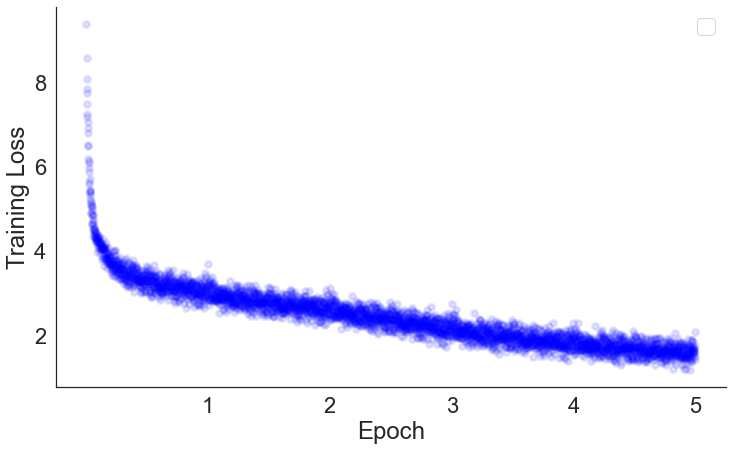

In [90]:

plt.figure(figsize = (12, 7))

plt.scatter(range(len(train_loss_list)), train_loss_list, color = 'blue', linewidth = 3, alpha=0.1)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.xticks(ticks = [(i+1)*len(train_loss_list)//num_epochs for i in range(num_epochs)], labels=[f"{i+1}" for i in range(num_epochs)])
plt.legend()
sns.despine()

In [95]:

def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (gen_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == eos_idx:
            break
    return ys


def translate(model, src_sentence):
    model.eval()
    src = text_transform[Source_langauge](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=bos_idx).flatten()
    return " ".join(vocab_transform[Target_langauge].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "").replace("<unk>", "")


In [96]:
for i in range(10):
    test_pair = test_pairs[-i]
    test_str_de = test_pair[0]
    test_str_en = test_pair[1]
    print(f"Target: {test_str_en}")
    print("Model output:", translate(transformer, test_str_de))
    print("")

#NEEDS MORE ATTENTION HEADS SO COMPLEXITY CAN BE FOUND, WILL DECREASE MODEL TRAINING SPEED BY A LOT

Target: A group of faithful shoppers bear the cold while one points to his favorite store.
Model output:   A group of musicians are gathered around his instruments while a third takes a break .       

Target: I think the construction work is going on here.
Model output:    An adult is about to work .        

Target: A motorcyclist speeding along a road on a green Kawasaki sport motorcycle.
Model output:   A motorcycle rider with a green balloon painted over green and white blanket .      

Target: Skater boy does a trick and gets his photo taken in midair.
Model output:    A soccer player is doing a trick trick while doing a trick .     

Target: People rock climbing and hiking near a lake.
Model output:    A rock climbing near a lake .         

Target: A man and woman are in the kitchen and a package of Challenge butter is in the foreground.
Model output:   A man and woman in the kitchen with a wooden van in the foreground .         

Target: A white man is seen in a swimming pool 